In [1]:
'''
author: Felix Hol
date: 2019 April 10
content: code to track mosquitoes, several filtering parameters will need tweaking depending on imaging parameters.
'''

import numpy as np
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') ### this is a workaround for a bug when running on macOS, may not be necessary anymore
import matplotlib.pyplot as plt
import os
import itertools as it
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import skimage
from skimage import data, io, util
from skimage.feature import (match_descriptors, peak_local_max, match_template, corner_peaks, corner_harris, plot_matches, BRIEF)
from skimage.color import rgb2gray
from skimage.draw import circle
from skimage.measure import label, regionprops
from skimage.morphology import binary_dilation, erosion, dilation, opening, binary_closing, closing, white_tophat, remove_small_objects, disk, black_tophat, skeletonize, convex_hull_image
from scipy import ndimage as ndi
import trackpy as tp
import pylab
import math
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime
from tqdm import tnrange
import pickle

In [2]:
dataDir = '/media/felix/Samsung_T5/Felix/biteData_FeDa/181206_01/01/'
saveDir = '/media/felix/Samsung_T5/Felix/biteData_FeDa/181206_01/181206_01processed/'
frames = pims.ImageSequence(dataDir+'/*.png', as_grey=True)

In [3]:
####create background image

start = 10
stop = len(frames) - 100
step = math.floor(len(frames)/25)

numBGframes = int(np.ceil((stop - start) /step) + 1)
frameSize = frames[1].shape
BG = np.zeros([frameSize[0], frameSize[1], numBGframes])

j = 1
for i in range(start, stop, step):
    j += 1
    BG[:, :, j - 1] = np.invert(frames[i])    

BG = np.median(BG, axis=2)

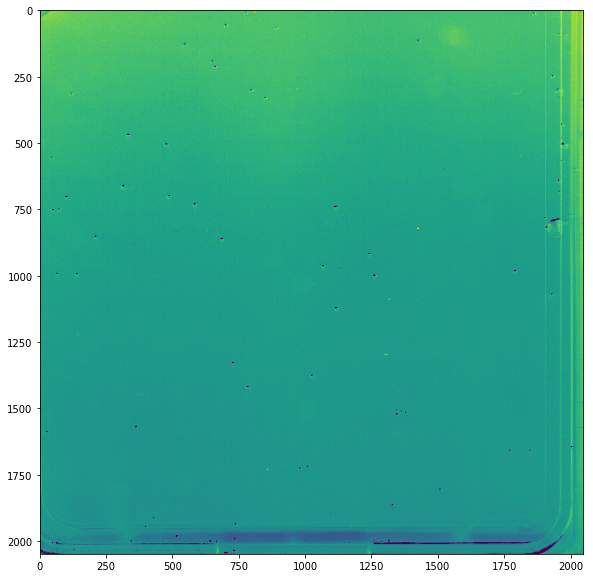

In [4]:
plt.figure(figsize=(25,10))
plt.imshow(BG)

In [5]:
#### get centroid and head coordinates

def trackMosq2(i):
    selem1 = disk(8)
    selem2 = disk(1)
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
    B = A - BG
    if B.min() > 0:
        Bm = B - B.min()
    else:
        Bm = B
    Bt = Bm > 40
    Bts = remove_small_objects(Bt, min_size=300)
    Be = erosion(Bts, selem2)
    Bf = remove_small_objects(Be, min_size=200)
    Bc = binary_closing(Bf, selem1)
    C = B * Bc
    eroded = erosion(C, selem2)
    eroded = skimage.filters.gaussian(eroded, 4)
    eroded[eroded < 0] = 0
    erL = label(eroded>0)
    erR = regionprops(erL, C, coordinates='xy')
    l = 1
    for props in erR:
        if props.area > 100000:
            erL[erL==l] = 0
        if props.major_axis_length > 1000:
            erL[erL==l] = 0
        l = l +1
    erLf = label(erL>0)
    erodedF = eroded * (erLf > 0)
    erRf = regionprops(erLf, C, coordinates='xy')
    centroids = np.zeros([len(erRf), 2])
    numCent = 0
    for props in erRf:
        centroids[numCent] = props.centroid
        numCent += 1
    coordinates = peak_local_max(eroded, min_distance=130, exclude_border=1)
    cS= coordinates.shape; numCoor = cS[0]
    cenS= centroids.shape; numCen = cenS[0]
    frameNo = i
    frameNoA = np.zeros((numCoor,1), dtype=np.int)
    frameNoCen = np.zeros((numCen,1), dtype=np.int)
    frameNoA[:] = frameNo
    frameNoCen[:] = frameNo
    coordinatesF = np.hstack((coordinates,frameNoA))
    centroidsF = np.hstack((centroids,frameNoCen))
    coordinatesF = np.hstack((coordinates,frameNoA))
    numCoords = coordinatesF.shape[0]
    numCents = centroidsF.shape[0]
    return centroidsF, coordinatesF, numCents, numCoords


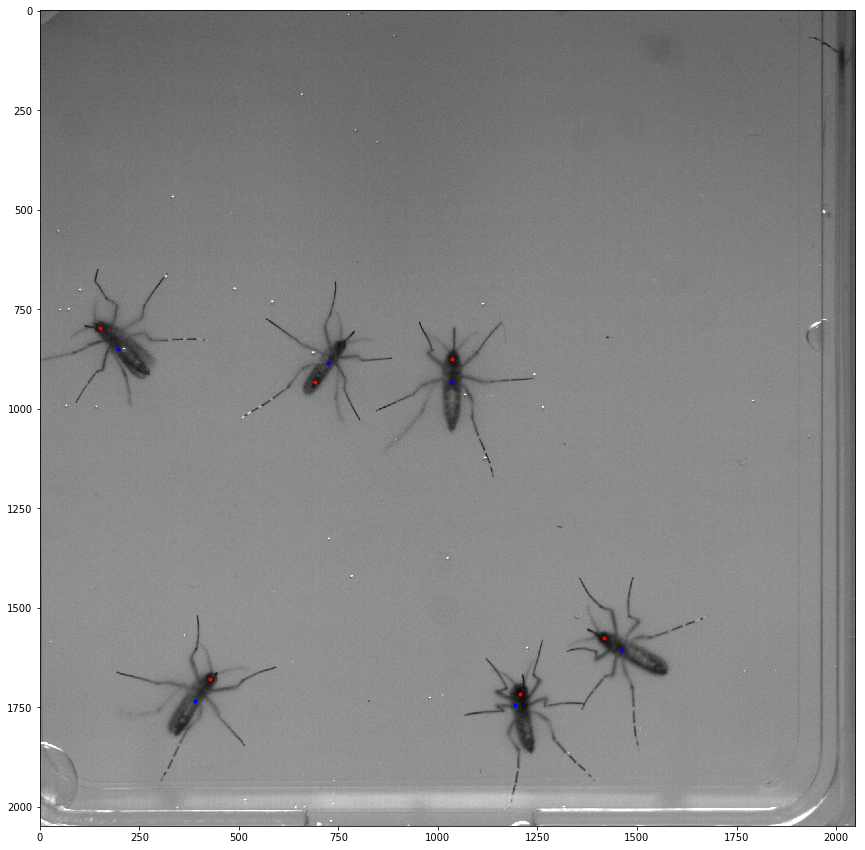

In [10]:
#####testing....
i = 153
centroidsF, coordinatesF, numCents, numCoords = trackMosq2(i)
plt.figure(figsize=(20,15))
plt.imshow(frames[i], cmap = 'gray')
plt.plot(coordinatesF[:,1],coordinatesF[:,0],'r.')
plt.plot(centroidsF[:,1],centroidsF[:,0],'b.')

In [ ]:
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(trackMosq2)(i) for i in tnrange(1, len(frames) - 1))

In [ ]:
centroidsAllT = np.zeros((1,3))
coordinatesAllT = np.zeros((1,3))

for i in range(len(results)):
    centroidsAllT = np.vstack((centroidsAllT,results[i][0]))
    coordinatesAllT = np.vstack((coordinatesAllT,results[i][1]))

In [ ]:
plt.figure(figsize=(25,10))
plt.imshow(frames[20], cmap = 'gray')
plt.plot(coordinatesAllT[:,1],coordinatesAllT[:,0],'r.')
plt.plot(centroidsAllT[:,1],centroidsAllT[:,0],'b.')

In [ ]:
os.chdir(saveDir)
with open('181211_01_02_full_CAndC01.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
df_cenAllT = pd.DataFrame(centroidsAllT)
df_cenAllT = df_cenAllT.rename(columns={0: "y", 1: "x", 2: "frame"})
df_cenAllT.head()

In [ ]:
t = tp.link_df(df_cenAllT, 400, memory=5)

In [ ]:
plt.figure(figsize=(25,10))
plt.imshow(frames[20], cmap='gray')
plt.plot(centroidsAllT[:,1],centroidsAllT[:,0],'r.',alpha=0.5, markersize=10)
tp.plot_traj(t, plot_style={'linewidth':'2.0'})

In [ ]:
os.chdir(saveDir)
t.to_pickle('181211_01_02_tracks.pkl')

In [ ]:
t.head()

In [ ]:
tFilt = tp.filter_stubs(t, 15)
tFilt.particle.unique()

In [ ]:
plt.figure(figsize=(25,10))
plt.imshow(frames[5], cmap='gray')
tp.plot_traj(tFilt.loc[tFilt['particle'] == 1.0], plot_style={'linewidth':'3.0'})

In [ ]:
def cropMos(p, t):
    
    frameWidth = 2048
    frameHeigth = 2048
    ROIwidth = 550
    ROIheigth = 550
    halfROIwidth = ROIwidth / 2
    halfROIheigth = ROIheigth / 2
    
    tP = t.loc[t['particle'] == p]
    for index, row in tP.iterrows():
        if row['x'] < halfROIwidth:
            x_start = 0
            x_stop = ROIwidth
        elif row['x'] + halfROIwidth > frameWidth:
            x_start = frameWidth - ROIwidth
            x_stop = frameWidth
        else:
            x_start = row['x'] - halfROIwidth
            x_stop = row['x'] + halfROIwidth
        if row['y'] < halfROIwidth:
            y_start = 0
            y_stop = ROIwidth
        elif row['y'] + halfROIwidth > frameWidth:
            y_start = frameWidth - ROIwidth
            y_stop = frameWidth
        else:
            y_start = row['y'] - halfROIwidth
            y_stop = row['y'] + halfROIwidth
        currFrame = frames[row['frame']]
        currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
        skimage.io.imsave("crop_p" + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png", currROI)


In [ ]:
t.head()

In [ ]:
os.chdir('/media/felix/Samsung_T5/Felix/biteData_FeDa/181211_01/181211_01_02crops/')

mosToCrop = tFilt.particle.unique()
num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(cropMos)(i, t) for i in mosToCrop)

In [ ]:
os.chdir('/media/felix/Samsung_T5/Felix/biteData_FeDa/181212_01/181212_02crops/')

frameWidth = 2048
frameHeigth = 2048
ROIwidth = 550
ROIheigth = 550
halfROIwidth = ROIwidth / 2
halfROIheigth = ROIheigth / 2

p = 3.0
tP = t.loc[t['particle'] == p]

for index, row in tP.iterrows():
    if row['x'] < halfROIwidth:
        x_start = 0
        x_stop = ROIwidth
    elif row['x'] + halfROIwidth > frameWidth:
        x_start = frameWidth - ROIwidth
        x_stop = frameWidth
    else:
        x_start = row['x'] - halfROIwidth
        x_stop = row['x'] + halfROIwidth
    if row['y'] < halfROIwidth:
        y_start = 0
        y_stop = ROIwidth
    elif row['y'] + halfROIwidth > frameWidth:
        y_start = frameWidth - ROIwidth
        y_stop = frameWidth
    else:
        y_start = row['y'] - halfROIwidth
        y_stop = row['y'] + halfROIwidth
    currFrame = frames[row['frame']]
    currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
    skimage.io.imsave("crop_p" + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png", currROI)

# .image.imsave('name.png', array)

In [ ]:
y_stop

In [ ]:
currFrame

In [ ]:
currROI